<a href="https://colab.research.google.com/github/bagasbudhi/Algorithm-Machine-Learning-KNN-SVM-data-Rokok/blob/master/Week_1_Dataphiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Klasifikasi Gambar menggunakan Deep Learning**

Pada kesempatan kali ini kita akan membahas seputar klasifikasi gambar menggunakan teknik deep learning. *Deep learning framework* yang digunakan adalah **PyTorch**

Pada notebook ini kita akan belajar mengenai beberapa topik:
1.   **Cara mempersiapkan dataset untuk proses pelatihan**
      *   Load dataset yang telah tersedia di PyTorch dan melakukan investigasi terhadap dataset
      *   Membuat dataloader untuk dataset
      *   Split dataset untuk traning dan validasi

2.   **Proses training**
      *   Komponen-Komponen untuk training
          *   Optimizer
          *   Criterion atau *loss function*
          *   Hyperparameter untuk training
              *   learning rate
              *   jumlah epoch
      *   Menghitung training loss

3.   **Proses validasi**
      *   Menghitung nilai akurasi validasi


4.   **Visualisasi training loss vs akurasi validasi**

5.   **Komparasi performa dua model yang berbeda**















**install library yang dibutuhkan**

Library yang dibutuhkan yaitu **torch** dan **torchvision**

*   **Torch**: Library yang berisi fungsi-fungsi matematis untuk deep learning sperti: *loss function*, optimizer, layer *neural network*, dsb
*   **Torchvision**: Library seputar computer vision task seperti: load dataset untuk klasifikasi gambar ataupun deteksi objek, load pre-trained weight model-model komputer vision, transformasi pada dataset (resize, rotate, flip dst), dsb



In [ ]:
!pip install torch
!pip install torchvision

**Import library yang telah terinstall**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

1.6.0+cu101
0.7.0+cu101
True


In [ ]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Visualisasi metric untuk training dan validasi**

Karena kita akan memvisualisasikan grafik training loss vs akurasi validasi, maka kita membuat fungsi khusus untuk tugas tersebut.

Visualisasi metric untuk training dan validasi penting karena akan membantu kita mengetahui apakah model yang kita buat mengalami overfitting, underfitting atau tidak dua-duanya. 

In [ ]:
def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

**Visualisasi Dataset**

Di bawah ini, kita membuat fungsi khusus untuk menampilkan dataset yang kita gunakan.

*   `output_label`: untuk mengkonversi label dataset ke nilai label aslinya. 
*   `show_data`: fungsi utama untuk visualisasi dataset



In [ ]:
class_names = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

In [ ]:
def output_label(label):
  global class_names
  input = (label.item() if type(label) == torch.Tensor else label)
  return class_names[input]

In [ ]:
def show_data(data_sample):
  IMAGE_SIZE = data_sample[0].shape[1]
  plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
  plt.title('y = '+ str(output_label(data_sample[1])))

**Download dataset**

Dataset yang akan kita gunakan untuk hari ini adalah Fashion MNIST Dataset. Dataset ini telah tersedia di **torchvision** dan dapat kita download secara langsung. Kita akan mendownload dataset ini menjadi 2 bagian yaitu dataset untuk training `train_dataset` dan dataset untuk validasi `validation_dataset`. Fashion MNIST Dataset memiliki 10 label kelas.

Kita juga melakukan sedikit inspeksi terhadap dataset untuk mengetahui informasi dasar seputar dataset seperti ukuran gambar, serta visualisasi gambar yang ada di dataset.

infomasi lebih lengkap seputar Fashion MNIST Dataset: (https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
train_dataset = dset.FashionMNIST(root='/data', train=True, download=True, transform=transforms.ToTensor())
validation_dataset = dset.FashionMNIST(root='/data', train=False, download=True, transform=transforms.ToTensor())

Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw


Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_dataset[0][0].shape


torch.Size([1, 28, 28])

In [ ]:
print("[INFO] number of training dataset = ", len(train_dataset))
print("[INFO] number of validation dataset = ", len(validation_dataset))

[INFO] number of training dataset =  60000
[INFO] number of validation dataset =  10000


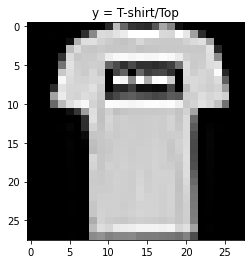

In [ ]:
show_data(train_dataset[1])

**Dataloader**

Selanjutnya, kita membuat dataloader untuk loading dataset. Keuntungan utama menggunakan dataloader yaitu ita dapat melakukan loading dataset kedalam ukuran-ukuran (batch) sesuai kemampuan memori. Hal ini dapat mempercepat proses training.




In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=True, num_workers=2)

**Fungsi untuk Training dan Validasi**

`train` merupakan fungsi untuk melakukan training dan validasi. Fungsi ini membutuhkan beberapa parameter:
*   `model`: model yang kita gunakan 
*   `criterion`: criterion yang kita gunakan untuk training
*   `train_loader` dan `validation_loader`: Dataloader untuk dataset training dan dataset validasi
*   `optimizer`: algoritma optimizer untuk training
*   `epochs`: jumlah epoch 
*   `model_type`: tipe model yang digunakan. Karena kita akan membandingkan performa 2 model yaitu CNN dan Neural Network biasa

Nilai training loss untuk setiap epoch merupakan rata-rata loss semua iterasi dalam satu epoch tersebut.

Nilai akurasi validasi dihitung berdasarkan jumlah kesamaan antara nilai prediksi oleh model dengan label/groundtruth





In [ ]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs, model_type):
    i = 0
    useful_stuff = {'training_loss': [],'validation_accuracy': []}  
    for epoch in range(epochs):
      cost = 0
      loss_epoch = 0
      for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        model.train()
        optimizer.zero_grad()
        if model_type == 'linear':
          z = model(x.view(-1, 28 * 28))
        else:
          z = model(x)
        
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost+=loss.data.item()
        #loss for every epoch
      loss_epoch = cost/len(train_loader)
      useful_stuff['training_loss'].append(loss_epoch)
      print("[INFO] Epoch:{}/{} train_loss:{}".format(epoch+1, epochs, loss_epoch))

      correct = 0
      for x, y in validation_loader:
        x, y = x.to(device), y.to(device)
        #validation
        model.eval()
        if model_type == 'linear':
          z = model(x.view(-1, 28 * 28))
        else:
          z = model(x)
        _, label = torch.max(z, 1)
        correct += (label == y).sum().item()
      accuracy = 100 * (correct / len(validation_dataset))
      useful_stuff['validation_accuracy'].append(accuracy)
      print("[INFO] Epoch:{}/{} val_acc:{}".format(epoch+1, epochs, accuracy))
    return useful_stuff

**Definisi Model (Linear)**

Pertama, kita akan membuat model *neural network* biasa terlebih dahulu. Model ini memiliki 1 *hidden layer* yang memiliki 100 *hidden cell*. 
```
  input    ===>  hidden layer   ===> output
(28*28)            (100)              (10)
```
Ukuran input harus sama dengan ukuran gambar. Karena dataset yang kita gunakan memiliki ukuran gambar `28*28`, maka ukuran input juga `28*28`. Sedangkan ukuran output 10 dikarenakan Fashion MNIST memiliki 10 lebel kelas.

In [ ]:
model_linear = nn.Sequential(
    nn.Linear(in_features=28*28, out_features=100),
    nn.Linear(in_features=100, out_features=10)
)
model_linear.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=10, bias=True)
)

**Komponen Training**

*   Criterion atau *loss function*: criterion yang dipakai menyesuaikan dengan masalah yang ingin diselesaikan. Karena masalah kita adalah *multi-class classification* maka kita menggunakan **cross entropy loss**. Criterion lain yang ada di PyTorch dapat dicek di https://pytorch.org/docs/stable/nn.html#loss-functions
*   Optimizer: di notebook ini kita menggunakan ***Stocastic Gradient Descent*** atau SGD dengan learning rate = 0.01. PyTorch mensupport banyak algoritma optimizer dan dapat dilihat di https://pytorch.org/docs/stable/optim.html



In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_linear.parameters(), lr=learning_rate)

**Training dan Validasi Model Linear**

Menggunakan model linear, kita dapat mencapai akurasi sebesar **83.96%** pada epoch ke 30. Kita akan membandingkan hasil ini dengan model yang lain yaiitu CNN. 

NB: jumlah epoch dan learning rate merupakan hyperparameter yang harus dituning untuk memberikan hasil terbaik. 

In [ ]:
training_results = train(model_linear, criterion, train_loader, validation_loader, optimizer, epochs=30, model_type='linear')

[INFO] Epoch:1/30 train_loss:1.196323267320792
[INFO] Epoch:1/30 val_acc:71.25
[INFO] Epoch:2/30 train_loss:0.7289589996139209
[INFO] Epoch:2/30 val_acc:76.09
[INFO] Epoch:3/30 train_loss:0.6302139144639174
[INFO] Epoch:3/30 val_acc:78.79
[INFO] Epoch:4/30 train_loss:0.5775263729691505
[INFO] Epoch:4/30 val_acc:79.86
[INFO] Epoch:5/30 train_loss:0.5438478055099646
[INFO] Epoch:5/30 val_acc:80.88
[INFO] Epoch:6/30 train_loss:0.5206022495528062
[INFO] Epoch:6/30 val_acc:81.33
[INFO] Epoch:7/30 train_loss:0.5034051454563936
[INFO] Epoch:7/30 val_acc:81.99
[INFO] Epoch:8/30 train_loss:0.49025867705543835
[INFO] Epoch:8/30 val_acc:82.15
[INFO] Epoch:9/30 train_loss:0.4797066680093606
[INFO] Epoch:9/30 val_acc:82.5
[INFO] Epoch:10/30 train_loss:0.47100037227074304
[INFO] Epoch:10/30 val_acc:82.67999999999999
[INFO] Epoch:11/30 train_loss:0.46368103752533596
[INFO] Epoch:11/30 val_acc:82.76
[INFO] Epoch:12/30 train_loss:0.4576263362665971
[INFO] Epoch:12/30 val_acc:82.95
[INFO] Epoch:13/30 tr

**Visualisasi Training Loss vs Akurasi Validasi Model Linear**

Dari grafik di bawah, kita dapat melihat bahwa semakin bertambahnya epoch, training loss semakin turun sedangkan akurasi validasi semakin meningkat. Ini menunjukan bahwa model kita melakukan proses "*learning*" dengan cukup baik. Berdasarkan grafik tersebut kita juga dapat menyimpulkan bahwa model tidak mengalami overfitting

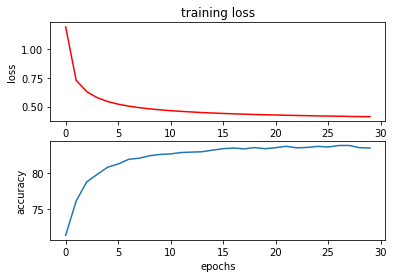

In [ ]:
plot_accuracy_loss(training_results)

**Definisi Model (CNN)**

Kali ini, kita akan mencoba menggunaan *Convolutional Neural Network* (CNN) untuk melakukan klasifikasi gambar. CNN sangat cocok untuk task yang menggunakan gambar sebagai inputnya. Hal ini dikarenakan CNN mampu mengekstrak korelasi spasial antar pixel dalam sebuah gambar sehingga fitur-fitur detail yang merepresentasikan gambar dapat diketahui. Fitur-fitur ini yang membedakan antara object yang satu dengan yang lain. Penjelasan detail seputar CNN dapat dilihat di https://cs231n.github.io/convolutional-networks/

Overview singkat arsitektur CNN yang digunakan:
```
input image  ==> conv1 ==> maxpool1 ==> conv2 ==> maxpool2 ==> linear1 ==> output
(28x28)       (24x24x16)  (12x12x16)  (8x8x32)    (4x4x32)       (512)       (10)
```

Sebelum masuk ke block linear, *feature map* pada blok konvolusi terakhir diubah ke vektor menggunakan fungsi `Flatten()`. Sehingga block linear memiliki hidden cell sebanyak 4x4x32 = 512 cell. Layer output memiliki jumlah cell 10 yang merepresentasikan jumlah label kelas pada Fashion MNIST



In [ ]:
model_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(in_features=32*4*4, out_features=10)
)
model_cnn.to(device)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=10, bias=True)
)

Kita menggunakan jenis criterion dan optimizer serta nilai learning rate yang sama dengan yang kita pakai untuk model linear.

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate)

**Training dan Validasi Model CNN**

Menggunakan model CNN kita dapat mencapai akurasi validasi sebesar **87.33%** pada epoch 30. Nilai ini jelas lebih baik dibandingkan model linear yang kita pakai sebelumnya. Hal ini menunjukan bahwa untuk data berjenis gambar CNN, memberi dapat memberikan hasil yang baik dibandingkan *neural network* biasa.

In [ ]:
training_results_cnn = train(model_cnn, criterion, train_loader, validation_loader, optimizer, epochs=30, model_type='cnn')

[INFO] Epoch:1/30 train_loss:1.424395472208659
[INFO] Epoch:1/30 val_acc:69.23
[INFO] Epoch:2/30 train_loss:0.6980312711497147
[INFO] Epoch:2/30 val_acc:73.94
[INFO] Epoch:3/30 train_loss:0.6067483057578404
[INFO] Epoch:3/30 val_acc:76.89
[INFO] Epoch:4/30 train_loss:0.5546249176561833
[INFO] Epoch:4/30 val_acc:79.32000000000001
[INFO] Epoch:5/30 train_loss:0.5192378741999467
[INFO] Epoch:5/30 val_acc:80.62
[INFO] Epoch:6/30 train_loss:0.4936698132753372
[INFO] Epoch:6/30 val_acc:82.23
[INFO] Epoch:7/30 train_loss:0.4721141495803992
[INFO] Epoch:7/30 val_acc:83.27
[INFO] Epoch:8/30 train_loss:0.4534670945008596
[INFO] Epoch:8/30 val_acc:83.44
[INFO] Epoch:9/30 train_loss:0.4420976731181145
[INFO] Epoch:9/30 val_acc:83.73
[INFO] Epoch:10/30 train_loss:0.4304922253141801
[INFO] Epoch:10/30 val_acc:84.67
[INFO] Epoch:11/30 train_loss:0.422265332788229
[INFO] Epoch:11/30 val_acc:83.65
[INFO] Epoch:12/30 train_loss:0.4119050591935714
[INFO] Epoch:12/30 val_acc:84.56
[INFO] Epoch:13/30 train

**Visualisasi Training Loss vs Akurasi Validasi Model CNN**

Berdasarkan grafik di bawah, kita dapat menyimpulkan model tidak mengalami overfitting yang ditunjukan oleh semakin berkurangnya training loss dan semakin meningkatnya akurasi validasi.

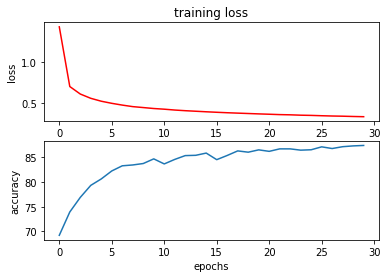

In [ ]:
plot_accuracy_loss(training_results_cnn)

### **Visualisasi hasil prediksi**

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [ ]:
def visualize_output(model, num_images=6):
  global class_names
  images_so_far = 0
  fig = plt.figure()

  for x, y in validation_loader:
    x, y = x.to(device), y.to(device)
    model.eval()
    z = model(x)
    _, label = torch.max(z, 1)

    for j in range(x.size()[0]):
      images_so_far += 1
      ax = plt.subplot(num_images//2, 2, images_so_far)
      ax.axis('off')
      ax.set_title('predicted: {}'.format(output_label(label[j])))
      imshow(x.cpu().data[j])

      if images_so_far == num_images:
        info = "Finish visualize output"
        return info

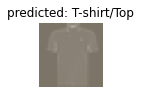

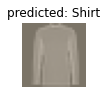

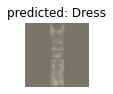

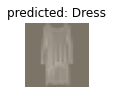

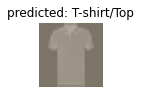

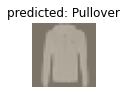

'Finish visualize output'

In [ ]:
visualize_output(model_cnn)

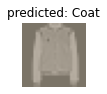

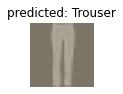

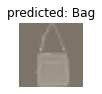

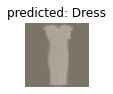

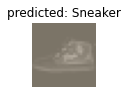

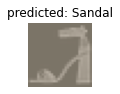

'Finish visualize output'

In [ ]:
visualize_output(model_linear)

**Transfer Learning: Menggunakan pre-trained model dari torchvision**

Torchvision menyediakan beberapa pre-trained model untuk klasifikasi gambar diantaranya VGG, Resnet, Alexnet dst. Cek di https://pytorch.org/docs/stable/torchvision/models.html. Untuk case kali ini, kita akan menggunakan pre-trained model resnet18. 


In [ ]:
model_pretrain = torchvision.models.resnet18(pretrained=True)
model_pretrain

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Karena Fashion MNIST memiliki format data yang berbeda dengan dataset yang digunakan untuk training resnet18 ini, ada beberapa step yang harus dilakukan.

1.   Merubah **convolutional layer pertama** dari resnet18 agar dapat menerima input dengan channel = 1 (gambar hitam putih)
2.   Merubah **linear layer terakhir** dari resnet18 agar memiliki jumlah output neuron = 10 (sesuai dengan jumlah kelas di Fashion MNIST)


In [ ]:
num_features = model_pretrain.fc.in_features
model_pretrain.conv1 = nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
model_pretrain.fc = nn.Linear(num_features, len(class_names))
model_pretrain.to(device)

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_pretrain.parameters(), lr=learning_rate)

In [ ]:
training_results_pretrain = train(model_pretrain, criterion, train_loader, validation_loader, optimizer, epochs=5, model_type='cnn')

[INFO] Epoch:1/5 train_loss:0.3423865712185701
[INFO] Epoch:1/5 val_acc:86.95
[INFO] Epoch:2/5 train_loss:0.29342149294912817
[INFO] Epoch:2/5 val_acc:87.57000000000001
[INFO] Epoch:3/5 train_loss:0.2618970094124476
[INFO] Epoch:3/5 val_acc:88.3
[INFO] Epoch:4/5 train_loss:0.23386682718992233
[INFO] Epoch:4/5 val_acc:88.86
[INFO] Epoch:5/5 train_loss:0.21108351199577252
[INFO] Epoch:5/5 val_acc:88.92999999999999


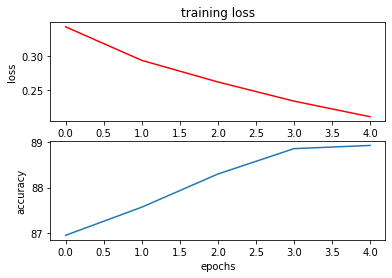

In [ ]:
plot_accuracy_loss(training_results_pretrain)

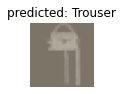

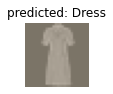

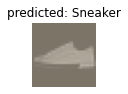

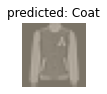

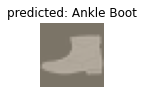

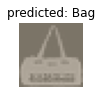

'Finish visualize output'

In [ ]:
visualize_output(model_pretrain)